# MVA - Homework 1 - Reinforcement Learning (2022/2023)

**Name:** ETCHEVERRY Matias

## Instructions

* The deadline is **November 10 at 11:59 pm (Paris time).**

* By doing this homework you agree to the late day policy, collaboration and misconduct rules reported on [Piazza](https://piazza.com/class/l4y5ubadwj64mb/post/6).

* **Mysterious or unsupported answers will not receive full credit**. A correct answer, unsupported by calculations, explanation, or algebraic work will receive no credit; an incorrect answer supported by substantially correct calculations and explanations might still receive partial credit.

* Answers should be provided in **English**.

# Colab setup

In [ ]:
from IPython import get_ipython

if 'google.colab' in str(get_ipython()):
  # install rlberry library
  !pip install git+https://github.com/rlberry-py/rlberry.git@mva2021#egg=rlberry[default] > /dev/null 2>&1

  # install ffmpeg-python for saving videos
  !pip install ffmpeg-python > /dev/null 2>&1

  # packages required to show video
  !pip install pyvirtualdisplay > /dev/null 2>&1
  !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

  print("Libraries installed, please restart the runtime!")


Libraries installed, please restart the runtime!


In [ ]:
# Create directory for saving videos
!mkdir videos > /dev/null 2>&1

# Initialize display and import function to show videos
import rlberry.colab_utils.display_setup
from rlberry.colab_utils.display_setup import show_video

In [ ]:
# Useful libraries
import numpy as np
import matplotlib.pyplot as plt
from time import time

# Preparation

In the coding exercises, you will use a *grid-world* MDP, which is represented in Python using the interface provided by the [Gym](https://gym.openai.com/) library. The cells below show how to interact with this MDP and how to visualize it.


In [ ]:
from rlberry.envs import GridWorld

def get_env():
  """Creates an instance of a grid-world MDP."""
  env = GridWorld(
      nrows=5,
      ncols=7,
      reward_at = {(0, 6):1.0},
      walls=((0, 4), (1, 4), (2, 4), (3, 4)),
      success_probability=0.9,
      terminal_states=((0, 6),)
  )
  return env

def render_policy(env, policy=None, horizon=50):
  """Visualize a policy in an environment

  Args:
    env: GridWorld
        environment where to run the policy
    policy: np.array
        matrix mapping states to action (Ns).
        If None, runs random policy.
    horizon: int
        maximum number of timesteps in the environment.
  """
  env.enable_rendering()
  state = env.reset()                       # get initial state
  for timestep in range(horizon):
      if policy is None:
        action = env.action_space.sample()  # take random actions
      else:
        action = policy[state]
      next_state, reward, is_terminal, info = env.step(action)
      state = next_state
      if is_terminal:
        break
  # save video and clear buffer
  env.save_video('./videos/gw.mp4', framerate=5)
  env.clear_render_buffer()
  env.disable_rendering()
  # show video
  show_video('./videos/gw.mp4')


[INFO] OpenGL_accelerate module loaded 
[INFO] Using accelerated ArrayDatatype 
[INFO] Generating grammar tables from /usr/lib/python3.7/lib2to3/Grammar.txt 
[INFO] Generating grammar tables from /usr/lib/python3.7/lib2to3/PatternGrammar.txt 
/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [ ]:
# Create an environment and visualize it
env = get_env()
render_policy(env)  # visualize random policy

# The reward function and transition probabilities can be accessed through
# the R and P attributes:
print(f"Shape of the reward array = (S, A) = {env.R.shape}")
print(f"Shape of the transition array = (S, A, S) = {env.P.shape}")
print(f"Reward at (s, a) = (1, 0): {env.R[1, 0]}")
print(f"Prob[s\'=2 | s=1, a=0]: {env.P[1, 0, 2]}")
print(f"Number of states and actions: {env.Ns}, {env.Na}")

# The states in the griworld correspond to (row, col) coordinates.
# The environment provides a mapping between (row, col) and the index of
# each state:
print(f"Index of state (1, 0): {env.coord2index[(1, 0)]}")
print(f"Coordinates of state 5: {env.index2coord[5]}")

Shape of the reward array = (S, A) = (31, 4)
Shape of the transition array = (S, A, S) = (31, 4, 31)
Reward at (s, a) = (1, 0): 0.0
Prob[s'=2 | s=1, a=0]: 0.04999999999999999
Number of states and actions: 31, 4
Index of state (1, 0): 6
Coordinates of state 5: (0, 6)


# Part 1 - Dynamic Programming

## Question 1.1

Consider a general MDP with a discount factor of $\gamma < 1$. Assume that the horizon is infinite (so there is no termination). A policy $\pi$ in this MDP
induces a value function $V^\pi$. Suppose an affine transformation is applied to the reward, what is
the new value function? Is the optimal policy preserved?



### **Answer**

Let 


* $\pi$ be a policy
* $s \in \mathcal{S}$ be any state
* $V^\pi(s)$ the value fonction at state $s$
* we apply an affine transformation to the reward ie $r'(s) = as+b$
* $W^\pi(s)$ the value fonction for transformed reward at state $s$

We have

$$
\begin{align}
V^\pi(s) & = \mathbb{E}\left[G_t | S_t=s\right] \\
& = \mathbb{E}\left[\sum_{k=0}^{\infty} \gamma^k R_{t+k+1} | S_t=s\right] \\
\end{align}
$$

So we have

$$
\begin{align}
W^\pi(s) & = \mathbb{E}\left[\sum_{k=0}^{\infty} \gamma^k (aR_{t+k+1} +b) | S_t=s\right] \\
& = aV^\pi(s) + \frac{b}{1-\gamma}
\end{align}
$$

We notice that for the optimal policy $\pi^*$, and for any policy $\pi$

$$V^{\pi^*}(s) \geq V^\pi(s)$$


*   if $a \geq 0$, we have
$$
\begin{align}
aV^{\pi^*}(s) + \frac{b}{1-\gamma} & \geq aV^{\pi}(s) + \frac{b}{1-\gamma}\\
W^{\pi^*}(s) & \geq W^{\pi}(s)
\end{align}
$$
So the optimal policy $\pi^*$ stay unchanged.

*   if $a < 0$, we have
$$
\begin{align}
aV^{\pi^*}(s) + \frac{b}{1-\gamma} & \leq aV^{\pi}(s) + \frac{b}{1-\gamma}\\
W^{\pi^*}(s) & \leq W^{\pi}(s)
\end{align}
$$
So the optimal policies are ordered in the reverse way. $\pi$ is now the worst policy.









## Question 1.2

Consider an infinite-horizon $\gamma$-discounted MDP. We denote by $Q^*$ the $Q$-function of the optimal policy $\pi^*$. Prove that, for any function $Q(s, a)$ (which is **not** necessarily the value function of a policy), the following inequality holds for any state $s$:

$$
V^{\pi_Q}(s) \geq V^*(s) - \frac{2}{1-\gamma}||Q^*-Q||_\infty,
$$

where $||Q^*-Q||_\infty = \max_{s, a} |Q^*(s, a) - Q(s, a)|$ and $\pi_Q(s) \in \arg\max_a Q(s, a)$. Can you use this result to show that any policy $\pi$ such that $\pi(s) \in \arg\max_a Q^*(s, a)$ is optimal?



### **Answer**

This answer was found thanks to my classmates' hints.

Let's consider

*   $Q(s,a)$ any 2 parameter function, and its associated policy $\pi_Q(s) \in \arg\max_a Q(s, a)$
*   $Q^*(s, a)$ the optimal state-action function, and its associated policy  $\pi^* \in \arg\max_\pi V^\pi(s)$

First of all, we need to notice:

$$
\begin{equation}
Q^*(s, \pi^*(s)) - Q(s, \pi^*(s)) \leq ||Q^* - Q||_\infty
\end{equation}
$$
and, by definition of $\pi_q(s) = arg \max\limits_{a \in A} Q(s, a)$

$$
\begin{equation}
Q(s, \pi_q(s)) \geq Q(s, \pi^*(s)) \\
ie \quad Q(s, \pi^*(s)) - Q^*(s, \pi_q(s)) \leq Q(s, \pi_q(s)) - Q^*(s, \pi_q(s))\leq ||Q^* - Q||_\infty\\
\end{equation}
$$
Thus, using the 2 previous statement, 

$$
\begin{equation}
2||Q^* - Q||_\infty \geq Q^*(s, \pi^*(s)) - Q^*(s, \pi_q(s))\\
ie \quad 2||Q^* - Q||_\infty \geq Q^*(s, \pi^*(s)) -Q^{\pi_q}(s, \pi_q(s)) + Q^{\pi_q}(s, \pi_q(s)) - Q^*(s, \pi_q(s))\\
\end{equation}
$$

About first 2 left terms:
\begin{equation}
 Q^*(s, \pi^*(s)) -Q^{\pi_q}(s, \pi_q(s)) = V^*(s) - V^{\pi_q}(s)
\end{equation}

About the 2 right terms:
\begin{align}
Q^{\pi_q}(s, \pi_q(s)) - Q^*(s, \pi_q(s)) & = \left(r(s, \pi_q(s)) + \gamma\sum\limits_{s' \in S} p(s'|s, \pi_q(s))V^{\pi_q}(s')\right) - \left(r(s, \pi_q(s)) + \gamma\sum\limits_{s' \in S} p(s'|s, \pi_q(s))V^*(s'))\right)\\ 
& = \gamma\sum\limits_{s' \in S} p(s'|s, \pi_q(s))\left(V^{\pi_q}(s')-V^*(s'))\right)\\
\end{align}

Let $s_0$ the state minimizing $V^{\pi_q}(s')-V^*(s')$ ie maximazing $V^*(s') - V^{\pi_q}(s')$. We have

\begin{align}
Q^{\pi_q}(s, \pi_q(s)) - Q^*(s, \pi_q(s)) & \geq \gamma V^{\pi_q}(s_0)-V^*(s_0)\\
\end{align}

The equation above is true for any state, so if we apply the whole en $s_O$, we have:

$$
\begin{align}
2||Q^* - Q||_\infty & \geq  V^*(s_0) - V^{\pi_q}(s_0) + \gamma V^{\pi_q}(s_0)-V^*(s_0)\\
& \geq (1 - \gamma) (V^*(s_0) - V^{\pi_q}(s_0))\\
& \geq (1 - \gamma) (V^*(s) - V^{\pi_q}(s)) \quad \text{for any state $s$, as it is maximzed by $s_0$}
\end{align}
$$

We then have, for any state $s$:
$$
\begin{equation}
2||Q^* - Q||_\infty \geq (1-\gamma)(V^*(s) - V^{\pi_q}(s))\\
\end{equation}
$$

In the end,

$$
V^{\pi_Q}(s) \geq V^*(s) - \frac{2}{1-\gamma}||Q^*-Q||_\infty,
$$

$Q(s, a)$ being any function, we can chose $Q(s, a) = Q^*(s, a)$, and still have $\pi(s) \in \arg\max_a Q(s, a) = \arg\max_a Q^*(s, a)$. We end up with

$$
V^{\pi}(s) \geq V^*(s),
$$

ie $\pi$ is optimal.

## Question 1.3

In this question, you will implement and compare the policy and value iteration algorithms for a finite MDP. 

Complete the functions `policy_evaluation`, `policy_iteration` and `value_iteration` below.


Compare value iteration and policy iteration. Highlight pros and cons of each method.

### **Answer**

Pros and cons of each method:

**Value iteration:**

* simpler and more intuitive algorithm
* more expensive to compute thus slowest method
* more iterations to converge ($1150$ iterations here)

**Value inversion:**

* very powerful in simple games
* fastest method in simple games
* almost exact result in simple games
* matrix inversion is $O(n^3)$, thus it would be much slower in high dimension

**Policy iteration:**

* more complex algorithm
* less expensive to compute thus faster than value iteration
* few iterations to converge ($4$ iterations here)




In [ ]:
def policy_evaluation(P, R, policy, gamma=0.9, tol=1e-2):
    """
    Args:
        P: np.array
            transition matrix (NsxNaxNs)
        R: np.array
            reward matrix (NsxNa)
        policy: np.array
            matrix mapping states to action (Ns)
        gamma: float
            discount factor
        tol: float
            precision of the solution
    Return:
        value_function: np.array
            The value function of the given policy
    """
    Ns, Na = R.shape
    # ====================================================
    value_function = np.zeros(Ns)
    error = tol + 1
    proba_policy = np.array([p[a] for p, a in zip(P, policy)])
    while error > tol:
        Vprime = R[np.arange(len(policy)), policy] + gamma * proba_policy @ value_function
        error = np.linalg.norm(value_function-Vprime)
        value_function = Vprime
    # ====================================================
    return value_function


In [ ]:
def policy_iteration(P, R, gamma=0.9, tol=1e-3):
    """
    Args:
        P: np.array
            transition matrix (NsxNaxNs)
        R: np.array
            reward matrix (NsxNa)
        gamma: float
            discount factor
        tol: float
            precision of the solution
    Return:
        policy: np.array
            the final policy
        V: np.array
            the value function associated to the final policy
    """
    Ns, Na = R.shape
    V = np.zeros(Ns)
    policy = np.ones(Ns, dtype=int)
    # ====================================================
    error = 1
    while error > 0:
        # Evaluation
        value_function = policy_evaluation(P, R, policy, gamma=gamma, tol=tol)

        # Improvement
        policyprime = np.zeros(Ns, dtype=int)
        for i in range(Ns):
            _v = R[i] + gamma * P[i, :, :] @ value_function
            policyprime[i] = np.argmax(_v)

        error = np.linalg.norm(policy - policyprime)
        policy = np.copy(policyprime)
    # ====================================================
    value_function = policy_evaluation(P, R, policy, gamma=gamma, tol=tol)
    return policy, value_function

In [ ]:
def value_iteration(P, R, gamma=0.9, tol=1e-3):
    """
    Args:
        P: np.array
            transition matrix (NsxNaxNs)
        R: np.array
            reward matrix (NsxNa)
        gamma: float
            discount factor
        tol: float
            precision of the solution
    Return:
        Q: final Q-function (at iteration n)
        greedy_policy: greedy policy wrt Qn
        Qfs: all Q-functions generated by the algorithm (for visualization)
    """
    Ns, Na = R.shape
    Q = np.zeros((Ns, Na))
    Qfs = [Q]
    # ====================================================
    value_function = np.zeros(Ns)
    error = tol + 1
    while error > tol:
        Qprime = np.zeros((Ns, Na))
        maxQ = np.max(Q, axis=1)

        for i in range(Ns):
            Qprime[i] = R[i] + gamma * np.sum((P[i, :, :] * maxQ[None, :]), axis=1)

        Qfs.append(Qprime)
        error = np.max(np.abs(Q-Qprime))
        Q = np.copy(Qprime)
    greedy_policy = np.argmax(Q, axis=1)
    # ====================================================
    return Q, greedy_policy, Qfs

### Testing your code

[VI]Greedy policy: 



[PI]final policy: 


Value iteration duration: 0.4045s
Value inversion duration: 0.0041s
Policy iteration duration: 0.1218s


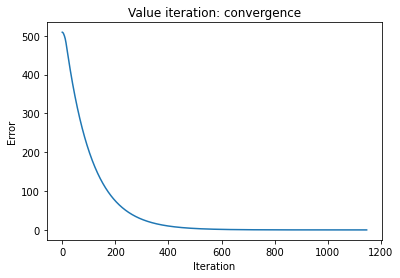

In [ ]:
# Parameters
tol = 1e-5
gamma = 0.99

# Environment
env = get_env()

# run value iteration to obtain Q-values
start_time = time()
VI_Q, VI_greedypol, all_qfunctions = value_iteration(env.P, env.R, gamma=gamma, tol=tol)
value_iteration_duration = time() - start_time

# render the policy
print("[VI]Greedy policy: ")
render_policy(env, VI_greedypol)

# compute the value function of the greedy policy using matrix inversion
# ====================================================
start_time = time()
Ns, Na = env.R.shape
Rpi = env.R[np.arange(len(VI_greedypol)), VI_greedypol]
Ppi = env.P[np.arange(len(VI_greedypol)), VI_greedypol, :]
greedy_V = np.linalg.inv(np.identity(Ns) - gamma * Ppi) @ Rpi
value_inversion_duration = time() - start_time
# ====================================================

# show the error between the computed V-functions and the final V-function
# (that should be the optimal one, if correctly implemented)
# as a function of time
final_V = all_qfunctions[-1].max(axis=1)
norms = [ np.linalg.norm(q.max(axis=1) - final_V) for q in all_qfunctions]
plt.plot(norms)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title("Value iteration: convergence")

#### POLICY ITERATION ####
start_time = time()
PI_policy, PI_V = policy_iteration(env.P, env.R, gamma=gamma, tol=tol)
policy_iteration_duration = time() - start_time
print("\n[PI]final policy: ")
render_policy(env, PI_policy)

## Uncomment below to check that everything is correct
assert np.allclose(PI_policy, VI_greedypol),\
    "You should check the code, the greedy policy computed by VI is not equal to the solution of PI"
assert np.allclose(PI_V, greedy_V), \
    "Since the policies are equal, even the value function should be"

print("Value iteration duration: {:.4f}s".format(value_iteration_duration))
print("Value inversion duration: {:.4f}s".format(value_inversion_duration))
print("Policy iteration duration: {:.4f}s".format(policy_iteration_duration))

plt.show()

# Part 2 - Tabular RL

## Question 2.1

The code below collects two datasets of transitions (containing states, actions, rewards and next states) for a discrete MDP.

For each of the datasets:

1. Estimate the transitions and rewards, $\hat{P}$ and $\hat{R}$.
2. Compute the optimal value function and the optimal policy with respect to the estimated MDP (defined by $\hat{P}$ and $\hat{R}$), which we denote by $\hat{\pi}$ and $\hat{V}$.
3. Numerically compare the performance of $\hat{\pi}$ and $\pi^\star$ (the true optimal policy), and the error between $\hat{V}$ and $V^*$ (the true optimal value function).

Which of the two data collection methods do you think is better? Why?

### **Answer**

Thanks to the above cell, we undestand that the second dataset (obtained with `get_uniform_dataset`) gives better results than the first dataset (obtained with `get_random_policy_dataset`). Indeed, using the second dataset:

* The estimation of $P$ and $R$ are closer to the groundtruth
* However, the estimation of $V$ is worse than the groundtruth. But fortunately, an optimal policy can be found with very different state functions, so this is not a problem.

I think it doesn't really make sense to compare the value of the policy as 2 very different policies may be optimal.

In the end, the second dataset provides consistently better results.

**Why ?**

The dataset obtained with `get_uniform_dataset` works better because it can explore more. For instance, `get_random_policy_dataset` may do loops on the same state / action, while it is very unlikely with `get_uniform_dataset`.

To illustrate this, we can consider an extreme case. Let's take the same game as before, but we add an island. Going or leaving the island is impossible, and being in the island gives no reward. With this new function, if we explore with a random policy whose beginning is in the island, we won't never get any information about the other part of the game. On the other hand, `get_uniform_dataset` will give some useful insights about the game.


In [ ]:
def get_random_policy_dataset(env, n_samples):
  """Get a dataset following a random policy to collect data."""
  states = []
  actions = []
  rewards = []
  next_states = []
  
  state = env.reset()
  for _ in range(n_samples):
    action = env.action_space.sample()
    next_state, reward, is_terminal, info = env.step(action)
    states.append(state)
    actions.append(action)
    rewards.append(reward)
    next_states.append(next_state)
    # update state
    state = next_state
    if is_terminal:
      state = env.reset()

  dataset = (states, actions, rewards, next_states)
  return dataset

def get_uniform_dataset(env, n_samples):
  """Get a dataset by uniformly sampling states and actions."""
  states = []
  actions = []
  rewards = []
  next_states = []
  for _ in range(n_samples):
    state = env.observation_space.sample()
    action = env.action_space.sample()
    next_state, reward, is_terminal, info = env.sample(state, action)
    states.append(state)
    actions.append(action)
    rewards.append(reward)
    next_states.append(next_state)

  dataset = (states, actions, rewards, next_states)
  return dataset


# Collect two different datasets
num_samples = 500
env = get_env()
dataset_1 = get_random_policy_dataset(env, num_samples)
dataset_2 = get_uniform_dataset(env, num_samples)


# Item 3: Estimate the MDP with the two datasets; compare the optimal value
# functions in the true and in the estimated MDPs

def estimate_p_r(dataset):
    P = np.zeros((Ns, Na, Ns))
    R = np.zeros((Ns, Na))

    counter_P = np.zeros((Ns, Na, Ns))
    counter_R = np.zeros((Ns, Na))

    for state, action, reward, next_state in zip(*dataset):
        P[state, action, next_state] += 1
        R[state, action] += reward

        counter_P[state, action, :] += 1
        counter_R[state, action] += 1

    P[counter_P > 0] /= counter_P[counter_P > 0]
    R[counter_R > 0] /= counter_R[counter_R > 0]
    
    return P, R

def norm_inf(A):
    return np.max(np.abs(A))

P_1, R_1 = estimate_p_r(dataset_1)
P_2, R_2 = estimate_p_r(dataset_2)

_, PI_1, all_qfunctions = value_iteration(P_1, R_1, gamma=gamma, tol=tol)
V_1 = all_qfunctions[-1].max(axis=1)

_, PI_2, all_qfunctions = value_iteration(P_2, R_2, gamma=gamma, tol=tol)
V_2 = all_qfunctions[-1].max(axis=1)

print("Distance from estimated P to env.P:")
print(f"\tDataset 1: {np.linalg.norm(P_1 - env.P)}, Dataset 2: {np.linalg.norm(P_2 - env.P)}")
print("Distance from estimated R to env.R:")
print(f"\tDataset 1: {np.linalg.norm(R_1 - env.R)}, Dataset 2: {np.linalg.norm(R_2 - env.R)}")
print("Distance from estimated V to V*")
print(f"\tDataset 1: {norm_inf(V_1 - greedy_V)}, Dataset 2: {norm_inf(V_2 - greedy_V)}")
print("Distance from estimated Pi to PI*")
print(f"\tDataset 1: {np.linalg.norm(PI_policy - PI_1)}, Dataset 2: {np.linalg.norm(PI_policy - PI_2)}")

print("Greedy policy on dataset 1: ")
render_policy(env, PI_1)

print("Greedy policy on dataset 1: ")
render_policy(env, PI_2)
    

Distance from estimated P to env.P:
	Dataset 1: 5.212026551495549, Dataset 2: 2.215443103676694
Distance from estimated R to env.R:
	Dataset 1: 1.7320508075688772, Dataset 2: 0.0
Distance from estimated V to V*
	Dataset 1: 98.76966849322514, Dataset 2: 1.8627574443141697
Distance from estimated Pi to PI*
	Dataset 1: 6.708203932499369, Dataset 2: 5.196152422706632
Greedy policy on dataset 1: 


Greedy policy on dataset 1: 


## Question 2.2

Suppose that $\hat{P}$ and $\hat{R}$ are estimated from a dataset of exactly $N$ i.i.d. samples from **each** state-action pair. This means that, for each $(s,a)$, we have $N$ samples $\{(s_1',r_1, \dots, s_N', r_N\}$, where $s_i' \sim P(\cdot | s,a)$ and $r_i \sim R(s,a)$ for $i=1,\dots,N$, and
$$ \hat{P}(s'|s,a) = \frac{1}{N}\sum_{i=1}^N \mathbb{1}(s_i' = s'), $$
$$ \hat{R}(s,a) = \frac{1}{N}\sum_{i=1}^N r_i.$$
Suppose that $R$ is a distribution with support in $[0,1]$. Let $\hat{V}$ be the optimal value function computed in the empirical MDP (i.e., the one with transitions $\hat{P}$ and rewards $\hat{R}$). For any $\delta\in(0,1)$, derive an upper bound to the error

$$ \| \hat{V} - V^* \|_\infty $$

which holds with probability at least $1-\delta$.

**Note** Your bound should only depend on deterministic quantities like $N$, $\gamma$, $\delta$, $S$, $A$. It should *not* dependent on the actual random samples.

**Hint** The following two inequalities may be helpful.

1. **A (simplified) lemma**. For any state $\bar{s}$,

$$ |\hat{V}(\bar{s}) - V^*(\bar{s})| \leq \frac{1}{1-\gamma}\max_{s,a} \left| R(s,a) - \hat{R}(s,a) + \gamma \sum_{s'}(P(s'|s,a) - \hat{P}(s'|s,a)) V^*(s') \right|$$

2. **Hoeffding's inequality**. Let $X_1, \dots X_N$ be $N$ i.i.d. random variables bounded in the interval $[0,b]$ for some $b>0$. Let $\bar{X} = \frac{1}{N}\sum_{i=1}^N X_i$ be the empirical mean. Then, for any $\epsilon > 0$,

$$ \mathbb{P}(|\bar{X} - \mathbb{E}[\bar{X}]| > \epsilon) \leq 2e^{-\frac{2N\epsilon^2}{b^2}}.$$

### **Answer**

Let

*   $ϵ$ the upper bound of $ \| \hat{V} - V^* \|_\infty $, for a probability $1-δ$.
* $\bar{s}$ any state in $S$.
* $|S|$ and the $|A|$ the cardinal of states and actions.

Then

$$ \left\{ |\hat{V}(\bar{s}) - V^*(\bar{s})| \geq \epsilon \right\} \subset \left\{  \frac{1}{1-\gamma}\max_{s,a} \left| R(s,a) - \hat{R}(s,a) + \gamma \sum_{s'}(P(s'|s,a) - \hat{P}(s'|s,a)) V^*(s') \right| \geq \epsilon \right\}$$

We set 

$$ 
\begin{align}
X(s, a) & = r_i + \gamma \sum_{s' \in S} 1_{s'=s}V^*(s') & r_i \sim R(s,a), & s_i' \sim P(\cdot | s,a)\\
\end{align}
$$

The $X(s, a)$ are all independant. Indeed, they may be seen as samples of some distributions, but they don't require any knowledge on the actual game.
Moreover, $X(s, a)$ are all bounded by the same value, denoted $b$:

$$ X(s, a) \leq 1 + \gamma \max_{s' \in S} V^*(s') = b$$


Thus, we have 

$$
\begin{align}
\left\{  \max_{s,a} \left| X(s, a) -  \mathbb{E}\left[X(s, a)\right] \right| \geq \epsilon(1-\gamma) \right\} & \subset \bigcup_{s \in S, a \in A} \biggl\{\left| X(s, a) -  \mathbb{E}\left[X(s, a)\right] \right| \geq \epsilon(1-\gamma) \biggr\}
\end{align}
$$
In the end, 
$$ \biggl\{ |\hat{V}(\bar{s}) - V^*(\bar{s})| \geq \epsilon \biggr\} \subset \bigcup_{s \in S, a \in A} \biggl\{\left| X(s, a) -  \mathbb{E}\left[X(s, a)\right] \right| \geq \epsilon(1-\gamma) \biggr\}
$$

This above equation is true for any state $\bar{s}$. Thus, it is true for the state $\bar{s}$ maximizing $|\hat{V}(\bar{s}) - V^*(\bar{s})|$, as there is a finite number of states.

We now have 

$$ 
\begin{align}
\mathbb{P} \left( \| \hat{V} - V^* \|_\infty \geq \epsilon \right) & \leq 
\mathbb{P} \left(  \bigcup_{s \in S, a \in A} \biggl\{\left| X(s, a) -  \mathbb{E}\left[X(s, a)\right] \right| \geq \epsilon(1-\gamma) \biggr\} \right) \\ 
& \leq \sum_{s \in S, a \in A} \mathbb{P} \left( \left| X(s, a) -  \mathbb{E}\left[X(s, a)\right] \right| \geq \epsilon(1-\gamma) \right)  \\
& \leq \sum_{s \in S, a \in A} 2\exp \left( -\frac{2Nϵ^2(1-\gamma)^2}{b^2} \right)   \\
\text{ie} \quad \mathbb{P} \left( \| \hat{V} - V^* \|_\infty \geq \epsilon \right) & \leq 2 |S||A| \exp \left( -\frac{2Nϵ^2(1-\gamma)^2}{b^2} \right) = \delta  \\
\end{align}
$$

In the end, by taking the only positive value for $ϵ$:

$$
ϵ = \frac{1 + \gamma \max\limits_{s' \in S} V^*(s') }{1-γ} \sqrt{- \frac{1}{2N} log \left( \frac{δ}{2|S||A|} \right) }
$$

One may assume that we don't know $V^s$ and thus, we can't access the value of $\max\limits_{s' \in S} V^*(s')$. To solve this issue, we can bound it, simply by assuming we receive a constant reward $r_{max}=1$ at each step:

$$
\max\limits_{s' \in S} V^*(s') \leq \frac{1}{1-\gamma}
$$

In that case, we have 


$$
ϵ = \frac{1}{(1-γ)^2} \sqrt{- \frac{1}{2N} log \left( \frac{δ}{2|S||A|} \right) }
$$

Below, I decide to plot the $ϵ$ value wrt to the number of samples $N$, with a fixed value $\delta=0.05$.

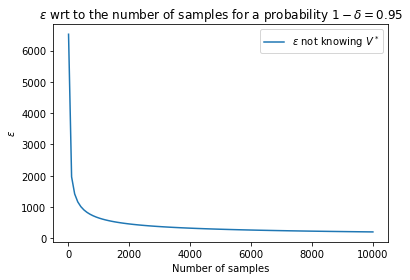

We need 10000 samples to get epsilon=206.2663450459011 with proba 0.95, not knowing V*


In [ ]:
from functools import partial

def compute_eps(N, V_star, gamma, delta, card_s, card_a):
    # Case 1: we know V_star
    if V_star is not None:
        b = 1 + gamma*max(V_star)
    # Case 2: we don't know V_star
    else:
        b = 1 + gamma/(1-gamma)
    return b / (1 - gamma) * np.sqrt( - 1 / (2*N) * np.log( delta / (2 * card_s * card_a)))

delta = 0.05
N = np.array([int(i) for i in np.linspace(10, 10000, 100, )])
eps_without_v_star = np.array(list(map(partial(compute_eps, V_star=None, gamma=0.99, delta=delta, card_s=Ns, card_a=Na), N)))
plt.plot(N, eps_without_v_star, label=r"$\epsilon$ not knowing $V^*$")
plt.ylabel(r"$\epsilon$")
plt.xlabel("Number of samples")
plt.title(r"$\epsilon$ wrt to the number of samples for a probability $1-\delta=0.95$")
plt.legend()
plt.show()
print(f"We need {N[-1]} samples to get epsilon={eps_without_v_star[-1]} with proba 0.95, not knowing V*")

## Question 2.3

Suppose once again that we are given a dataset of $N$ samples in the form of tuples $(s_i,a_i,s_i',r_i)$. We know that each tuple contains a valid transition from the true MDP, i.e., $s_i' \sim P(\cdot | s_i, a_i)$ and $r_i \sim R(s_i,a_i)$, while the state-action pairs $(s_i,a_i)$ from which the transition started can be arbitrary.

Suppose we want to apply Q-learning to this MDP. Can you think of a way to leverage this offline data to improve the sample-efficiency of the algorithm? What if we were using SARSA instead?

### **Answer**

We can levarage this dataset by using the Tabular Dyna-Q algorithm proposed by Sutton and Barto in 2018. This algorith aims at updating Q, based on observations. Those observations are obtained with an $\epsilon$-greedy policy. At every iteration, we are supposed to select an action based on the $\epsilon$-greedy policy. In our case, instead of choosing a random action with probability $\epsilon$, we choose a random policy in our dataset with probability $\epsilon$. At each iteration, we have

$$
\begin{equation}
Q(s, a) ← Q(s, a) + \alpha_t(s, a)\left(r + \gamma \max_{a'}Q(s′, a′) − Q(s, a)\right)
\end{equation}
$$
With a sufficient large dataset, we can compute the maximum easily.

I think we can do the same with SARSA. Indeed, SARSA is an on policy algorithm. The idea behind SARSA is to update a policy $\pi$ iteratively. To do so, we can initialize a policy $\pi = \pi_0 = \text{going left in every state}$ and update it using:

$$
\begin{equation}
Q(s, a) ← Q(s, a) + \alpha_t(s, a)\left(r + \gamma Q(s′, a′) − Q(s, a)\right)
\end{equation}
$$

Here $a'$ denotes the action obtained following the policy. We then update the policy $\pi$ as being the greedy policy of $Q$.


# Part 3 - RL with Function Approximation

## Question 3.1

Given a datset $(s_i, a_i, r_i, s_i')$ of (states, actions, rewards, next states), the Fitted Q-Iteration (FQI) algorithm proceeds as follows:


* We start from a $Q$ function $Q_0 \in \mathcal{F}$, where $\mathcal{F}$ is a function space;
* At every iteration $k$, we compute $Q_{k+1}$ as:

$$
Q_{k+1}\in\arg\min_{f\in\mathcal{F}} \frac{1}{2}\sum_{i=1}^N
\left(
  f(s_i, a_i) - y_i^k
\right)^2 + \lambda \Omega(f)
$$
where $y_i^k = r_i + \gamma \max_{a'}Q_k(s_i', a')$, $\Omega(f)$ is a regularization term and $\lambda > 0$ is the regularization coefficient.


Consider FQI with *linear* function approximation. That is, for a given feature map $\phi : S \rightarrow \mathbb{R}^d$, we consider a parametric family of $Q$ functions $Q_\theta(s,a) = \phi(s)^T\theta_a$ for $\theta_a\in\mathbb{R}^d$. Suppose we are applying FQI on a given dataset of $N$ tuples of the form $(s_i, a_i, r_i, s_i')$ and we are at the $k$-th iteration. Let $\theta_k \in\mathbb{R}^{d \times A}$ be our current parameter. Derive the *closed-form* update to find $\theta_{k+1}$, using $\frac{1}{2}\sum_a ||\theta_a||_2^2$ as regularization.

### **Answer**

Let $N$ the number of samples, made of $(s_i, a_i, r_i, s_i')$

Let the objective function: 

\begin{equation}
O(\theta) = \frac{1}{2}\sum_{i=1}^N
\left(
  \phi(s_i)^T\theta_{a_i} - y_i^k
\right)^2 + \lambda \frac{1}{2}\sum_a ||\theta_a||_2^2
\end{equation}

This objective function is convex wrt to $\theta_a$ and coercive. Thus it admits a minimum $\theta_a^*$ which cancels the gradient. Let's compute the gradient wrt to $\theta_{a}$, with $a \in A$.

\begin{equation}
\frac{\partial O}{\partial \theta_{a}} = \sum\limits_{s_i \in S | a_i = a} \phi(s_i) \left( \phi(s_i)^T\theta_a - y_i \right) + \lambda\theta_a
\end{equation}

Thus, cancelling the gradient is equivalent to:

\begin{align}
\frac{\partial O}{\partial \theta_{a}} = 0  & \Longleftrightarrow  \sum\limits_{s_i \in S | a_i = a} \phi(s_i) \left( \phi(s_i)^T\theta_a - y_i \right) + \lambda\theta_a = 0 \\
& \Longleftrightarrow \theta_a \left( \lambda I + \sum\limits_{s_i \in S | a_i = a} \phi(s_i)\phi(s_i)^T\right) =  \sum\limits_{s_i \in S | a_i = a} \phi(s_i)y_i^k \\
\end{align}

In the end, the equation above leads to solving iteratively on $k$

\begin{equation}
\theta_{k, a} = \left( \lambda I + \sum\limits_{s_i \in S | a_i = a} \phi(s_i)\phi(s_i)^T\right)^{-1} \sum\limits_{s_i \in S | a_i = a} \phi(s_i)y_i^k  \quad \text{for all } a \in A
\end{equation}

Note: $y_i^k$ depends on $\theta_{k-1, \cdot}$



## Question 3.2

The code below creates a larger gridworld (with more states than the one used in the previous questions), and defines a feature map. Implement linear FQI to this environment (in the function `linear_fqi()` below), and compare the approximated $Q$ function to the optimal $Q$ function computed with value iteration.

Can you improve the feature map in order to reduce the approximation error?

### **Answer**

[explanation about how you tried to reduce the approximation error + FQI implementation below]

In [ ]:
def get_large_gridworld():
  """Creates an instance of a grid-world MDP with more states."""
  walls = [(ii, 10) for ii in range(15) if (ii != 7 and ii != 8)]
  env = GridWorld(
      nrows=15,
      ncols=15,
      reward_at = {(14, 14):1.0},
      walls=tuple(walls),
      success_probability=0.9,
      terminal_states=((14, 14),)
  )
  return env


class GridWorldFeatureMap:
  """Create features for state-action pairs
  
  Args:
    dim: int
      Feature dimension
    sigma: float
      RBF kernel bandwidth
  """
  def __init__(self, env, dim=15, sigma=0.25):
    self.index2coord = env.index2coord
    self.n_states = env.Ns
    self.n_actions = env.Na
    self.dim = dim
    self.sigma = sigma

    n_rows = env.nrows
    n_cols = env.ncols

    # build similarity matrix
    sim_matrix = np.zeros((self.n_states, self.n_states))
    for ii in range(self.n_states):
        row_ii, col_ii = self.index2coord[ii]
        x_ii = row_ii / n_rows
        y_ii = col_ii / n_cols
        for jj in range(self.n_states):
            row_jj, col_jj = self.index2coord[jj]
            x_jj = row_jj / n_rows
            y_jj = col_jj / n_cols
            dist = np.sqrt((x_jj - x_ii) ** 2.0 + (y_jj - y_ii) ** 2.0)
            sim_matrix[ii, jj] = np.exp(-(dist / sigma) ** 2.0)

    # factorize similarity matrix to obtain features
    uu, ss, vh = np.linalg.svd(sim_matrix, hermitian=True)
    self.feats = vh[:dim, :]

  def map(self, observation):
    feat = self.feats[:, observation].copy()
    return feat

In [ ]:
env = get_large_gridworld()
feat_map = GridWorldFeatureMap(env)

# Visualize large gridworld
render_policy(env)

# The features have dimension (feature_dim).
feature_example = feat_map.map(1) # feature representation of s=1
print(feature_example)

# Initial vector theta representing the Q function
theta = np.zeros((feat_map.dim, env.action_space.n))
print(theta.shape)
print(feature_example @ theta) # approximation of Q(s=1, a)

[-0.02850699  0.063555   -0.02169407 -0.06441918  0.04505794 -0.07537777
  0.08506473 -0.09325287  0.09644275 -0.00535101  0.11632395 -0.13074085
  0.00921342 -0.13853662  0.07118419]
(15, 4)
[0. 0. 0. 0.]


100%|██████████| 500/500 [00:18<00:00, 27.49it/s]


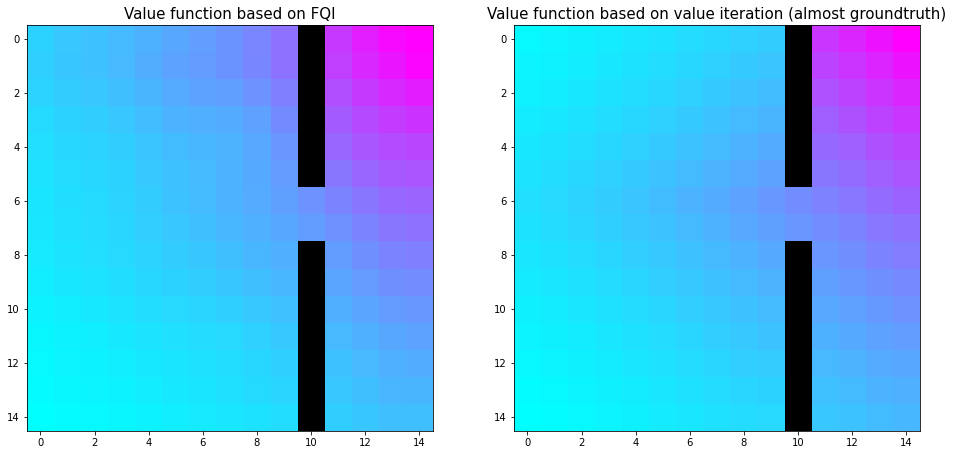

In [ ]:
from tqdm import trange

def linear_fqi(env, feat_map, num_iterations, lambd=0.1, gamma=0.95):
    """
    # Linear FQI implementation
    # TO BE COMPLETED
    """

    # get a dataset
    #    dataset = get_uniform_dataset(env, n_samples=...)
    # OR dataset = get_random_policy_dataset(env, n_samples=...)

    states, actions, rewards, next_states = get_uniform_dataset(env, n_samples=10000)
    theta = np.zeros((feat_map.dim, env.Na))
    state_features = np.array([feat_map.map(s) for s in range(env.Ns)])
    d = state_features.shape[1]
    for it in trange(num_iterations):
        Qk = state_features @ theta

        for action in range(env.Na):
            index_actions = np.array(actions) == action
            _states = np.array(states)[index_actions]
            _rewards = np.array(rewards)[index_actions]
            _next_states = np.array(next_states)[index_actions]

            y =_rewards +  gamma *np.max(Qk[_next_states, :], axis=1)

            a = lambd * np.eye(d) + state_features[_states].T @ state_features[_states]
            b = np.sum(state_features[_states] * y[:, None], axis=0)
            theta[:, action] = np.linalg.solve(a, b)
    return theta

# ----------------------------
# Environment and feature map
# ----------------------------
env = get_large_gridworld()
# you can change the parameters of the feature map, and even try other maps!
feat_map = GridWorldFeatureMap(env, dim=50, sigma=0.25)

# -------
# Run FQI
# -------
theta = linear_fqi(env, feat_map, num_iterations=500)

# Compute and run greedy policy
Q_fqi = np.zeros((env.Ns, env.Na))
for ss in range(env.Ns):
  state_feat = feat_map.map(ss)
  Q_fqi[ss, :] = state_feat @ theta

V_fqi = Q_fqi.max(axis=1)
policy_fqi = Q_fqi.argmax(axis=1)
render_policy(env, policy_fqi, horizon=100)

# Compute VI on value iteration
VI_Q, VI_greedypol, all_qfunctions = value_iteration(env.P, env.R, gamma=0.95, tol=10e-5)

# Visualize the approximate value function in the gridworld.
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
img = env.get_layout_img(V_fqi)    
axs[0].imshow(img)
axs[0].set_title("Value function based on FQI", fontsize=15)
img = env.get_layout_img(all_qfunctions[-1].max(axis=1))    
axs[1].imshow(img)
axs[1].set_title("Value function based on value iteration (almost groundtruth)", fontsize=15)
plt.show()

In order to improve the FQI:

* I increased the number of dimensions for the feature maps, from $d=15$ to $d=50$. The idea of feature maps is to encode state in a space of dimensions $d$, with $d \ll N_s=212$. Obviously this condition is not met anymore.
* I increased the value of sigma. 
* I increased the number of iteration up to 500.

We see in our case that the results are not so good, with FQI:

* the computational time is much greater than value iteration (or any method)
* the found value function is not really good. For instance:
    * we see that the tunnel up to the goal should show some purple, more than any other area, in order to guide the agent in it. This is not the case in FQI
    * the areas blocked by the wall should be blue. This is not the case either. 

Those problem are due to the linear approximation. Indeed, the vector $\theta_{a = \text{going left}}$ encodes a general good idea, even when the agent is blocked by the wall.